# Instacart Market Basket Analysis
## Objective: Predict which products will be reordered in the next order
Setting up:

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None

## What data do we have?
List of available files:

In [2]:
from subprocess import check_output
print(check_output(["ls", "../data/raw"]).decode("utf8"))

aisles.csv
departments.csv
order_products__prior.csv
order_products__train.csv
orders.csv
products.csv
sample_submission.csv



Reading in the files: (who uses two underscores?!)

In [4]:
order_products_train_df = pd.read_csv("../data/raw/order_products__train.csv")
order_products_prior_df = pd.read_csv("../data/raw/order_products__prior.csv")
orders_df = pd.read_csv("../data/raw/orders.csv")
products_df = pd.read_csv("../data/raw/products.csv")
aisles_df = pd.read_csv("../data/raw/aisles.csv")
departments_df = pd.read_csv("../data/raw/departments.csv")

### Orders: 
Contains meta information about the orders:
* order_id : Id of the order (int)
* user_id : user who ordered the order (int)
* eval_set : In what subset-file of all orders is this order? (prior, train, test)
* order_number : First, Second, ... order of this customer (0-100)
* order_dow : Day of the week of this order. No info on which number is which day (int 0-6)
* order_hour_of_day : Hour of ordering (int 0-23)
* days_since_prior_order : Days passed sind last order (float, can be NaN)

In [38]:
orders_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [36]:
orders_df.describe()

,order_id,user_id,order_number,order_dow,order_hour_of_day,days_since_prior_order
count,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.421083e+06,3.214874e+06
mean,1.710542e+06,1.029782e+05,1.715486e+01,2.776219e+00,1.345202e+01,1.111484e+01
std,9.875817e+05,5.953372e+04,1.773316e+01,2.046829e+00,4.226088e+00,9.206737e+00
min,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,8.552715e+05,5.139400e+04,5.000000e+00,1.000000e+00,1.000000e+01,4.000000e+00
50%,1.710542e+06,1.026890e+05,1.100000e+01,3.000000e+00,1.300000e+01,7.000000e+00
75%,2.565812e+06,1.543850e+05,2.300000e+01,5.000000e+00,1.600000e+01,1.500000e+01
max,3.421083e+06,2.062090e+05,1.000000e+02,6.000000e+00,2.300000e+01,3.000000e+01


### Order products .csv
The last order of each customer is split from his previous orders. The last orders are split between train (known) and test (unknown).
* **Pior**: All orders of a customer except his last one (32.434.489 items ordered)
* **Train**: The last orders for some of the customers (138.461 items ordered)
* **Test**(unknown): The last orders not included in train (75.000 items ordered)

Contains info about which products were ordered, in what order they were added into the cart and if this product is a reorder

In [47]:
order_products_train_df.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [79]:
users_amnt = orders_df.groupby('eval_set').user_id.nunique()
print("# of users:" , users_amnt.prior)
print("# of users in train: ", users_amnt.train)
print("# of users in test: ", users_amnt.test)

# of users: 206209
# of users in train:  131209
# of users in test:  75000


### Products.csv
More information about the products in the supermarket (49.688 in total)
Name, aisle and department

In [48]:
products_df.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


### Aisles.csv
Name of the aisles that exist (134 in total)

In [53]:
aisles_df.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


### Departments.csv
Names of the departments that exist (21 in total)

In [58]:
departments_df.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


## Some data visualization

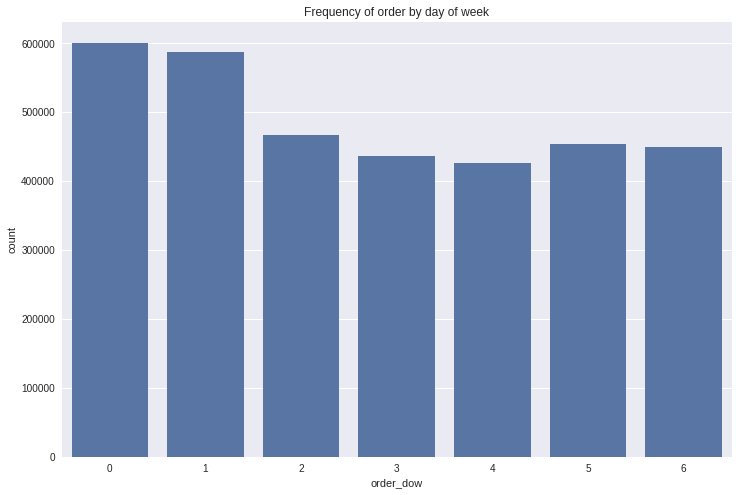

In [100]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_dow", data=orders_df, color=color[0])
plt.title("Frequency of order by day of week")
plt.show()

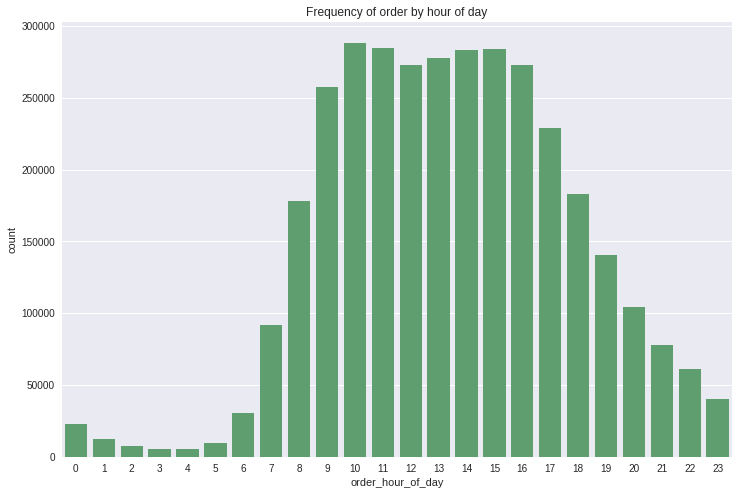

In [101]:
plt.figure(figsize=(12,8))
sns.countplot(x="order_hour_of_day", data=orders_df, color=color[1])
plt.title("Frequency of order by hour of day")
plt.show()

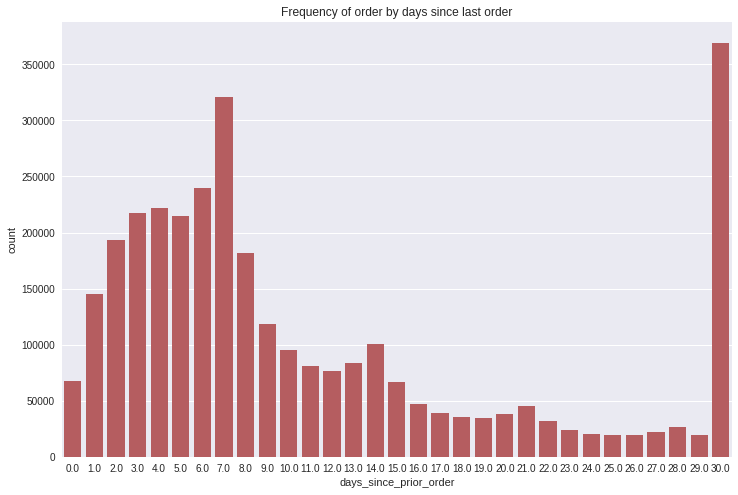

In [104]:
plt.figure(figsize=(12,8))
sns.countplot(x="days_since_prior_order", data=orders_df, color=color[2])
plt.title("Frequency of order by days since last order")
plt.show()

Percentage of reorders in prior set:

In [105]:
order_products_prior_df.reordered.sum() / order_products_prior_df.shape[0]

0.5896974667922161

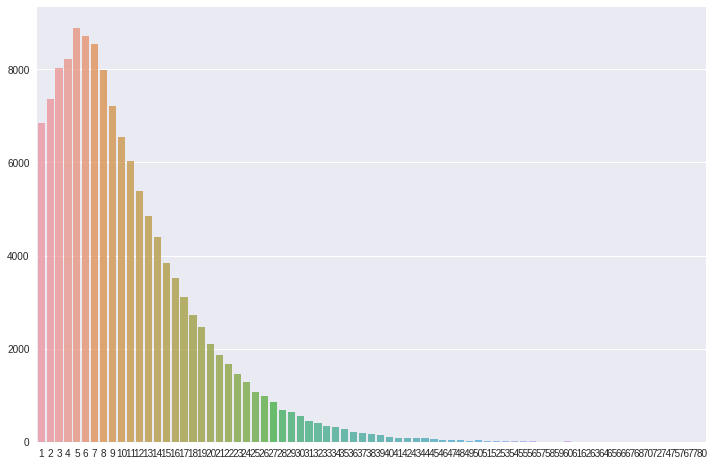

In [5]:
grouped_df = order_products_train_df.groupby("order_id")["add_to_cart_order"].aggregate("max").reset_index()
cnt_srs = grouped_df.add_to_cart_order.value_counts()

plt.figure(figsize=(12,8))
sns.barplot(cnt_srs.index, cnt_srs.values, alpha=0.8)
plt.show()